<a href="https://colab.research.google.com/github/viferraro/RedesFakeNews/blob/main/WELFAKELSTM16_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando a biblioteca openpyxl para trabalhar com arquivos Excel no Pandas

In [1]:
!pip install openpyxl


Instala o Tensorflow

In [2]:
!pip install tensorflow

Importa as bibliotecas necessárias

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


Valor usado para inicializar o gerador de números aleatórios

In [4]:
SEED = 10

Para acessar o banco de dados no Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Usa a biblioteca Pandas para ler o arquivo contendo o banco de dados

In [6]:
df = pd.read_excel('/content/drive/MyDrive/BDs/WELFake.xlsx')
df = df.sample(n=len(df), random_state=SEED)
df.dropna(subset=['text', 'title'], inplace=True)
df['text'] = df['title'] + ' ' + df['text']
X = df['text']
y = df['label']

Cria uma função que retorna o número de palavras e cria os gráficos

Text(0.5, 1.0, 'Distribuição da contagem de palavras')

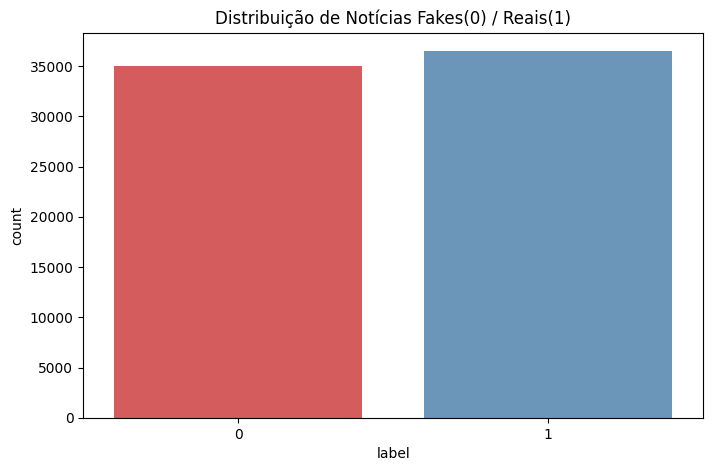

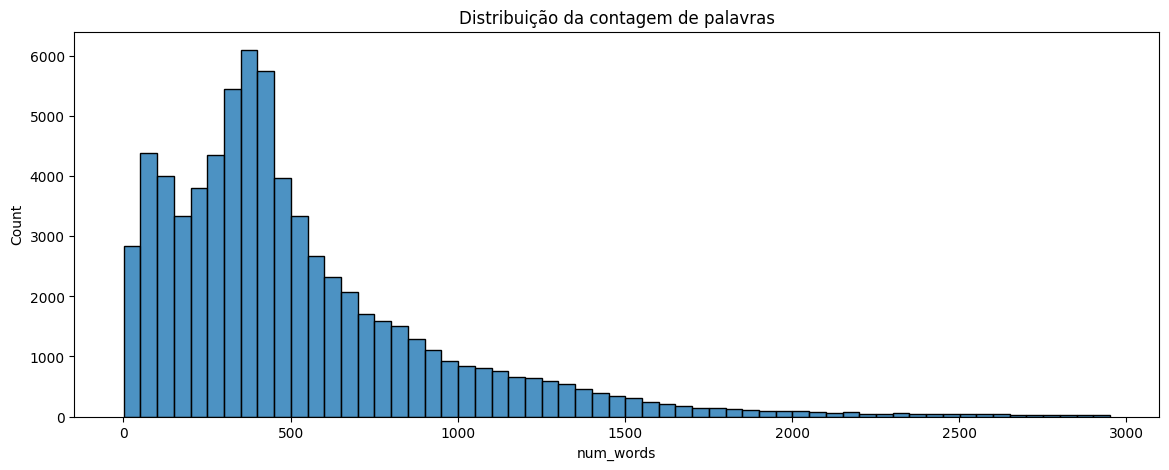

In [7]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize = (8,5))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribuição de Notícias Fakes(0) / Reais(1)')
plt.figure(figsize = (14,5))
sns.histplot(df['num_words'], bins = range(1, 3000, 50), alpha = 0.8)
plt.title('Distribuição da contagem de palavras')

Cria o modelo

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)


def get_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(16)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           100000    
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               8576      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 108,609
Trainable params: 108,609
Non-trainable params: 0
__________________________________________________

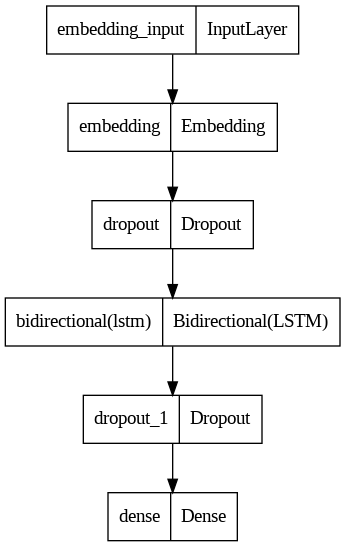

In [9]:
vocab_size = 2000
embedding_dim = 50
max_length = 100
model = get_model(vocab_size, embedding_dim, max_length)
model.summary()
tf.keras.utils.plot_model(model)

Cria um modelo Bert pré-treinado e treina o modelo usando os dados

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
model = get_model(vocab_size, embedding_dim, max_length)
history = model.fit(x=X_train_seq,
                    y=y_train,
                    validation_data=(X_val_seq, y_val),
                    epochs=10,
                    batch_size=16,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3,
                                             verbose=False,
                                             restore_best_weights=True)])


Epoch 1/10
2862/2862 [==============================] - 70s 21ms/step - loss: 0.3257 - accuracy: 0.9168 - val_loss: 0.3061 - val_accuracy: 0.9126
Epoch 2/10
2862/2862 [==============================] - 35s 12ms/step - loss: 0.2434 - accuracy: 0.9489 - val_loss: 0.2191 - val_accuracy: 0.9542
Epoch 3/10
2862/2862 [==============================] - 35s 12ms/step - loss: 0.2109 - accuracy: 0.9552 - val_loss: 0.1922 - val_accuracy: 0.9571
Epoch 4/10
2862/2862 [==============================] - 33s 12ms/step - loss: 0.2049 - accuracy: 0.9604 - val_loss: 0.2014 - val_accuracy: 0.9594
Epoch 5/10
2862/2862 [==============================] - 35s 12ms/step - loss: 0.1928 - accuracy: 0.9649 - val_loss: 0.1846 - val_accuracy: 0.9607
Epoch 6/10
2862/2862 [==============================] - 34s 12ms/step - loss: 0.1838 - accuracy: 0.9657 - val_loss: 0.1818 - val_accuracy: 0.9598
Epoch 7/10
2862/2862 [==============================] - 33s 12ms/step - loss: 0.1763 - accuracy: 0.9683 - val_loss: 0.1728 -

Cria gráficos que que mostram o desempenho do modelo

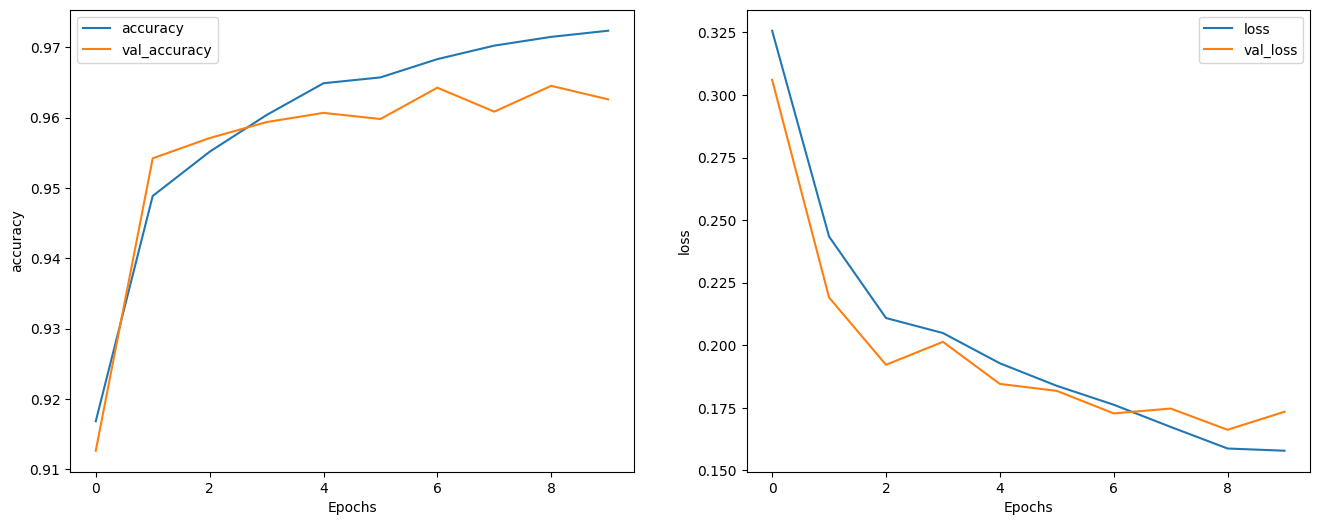

In [11]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Usa o modelo para fazer previsões nos dados de teste

In [12]:
yhat = np.where(model.predict(X_test_seq) >= 0.5, 1, 0)

448/448 [==============================] - 3s 5ms/step


Imprime um relatório de classificação

In [13]:
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7006
           1       0.95      0.97      0.96      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



Cria um diagrama mostrando a matriz de confusão

Text(70.72222222222221, 0.5, 'Real Labels')

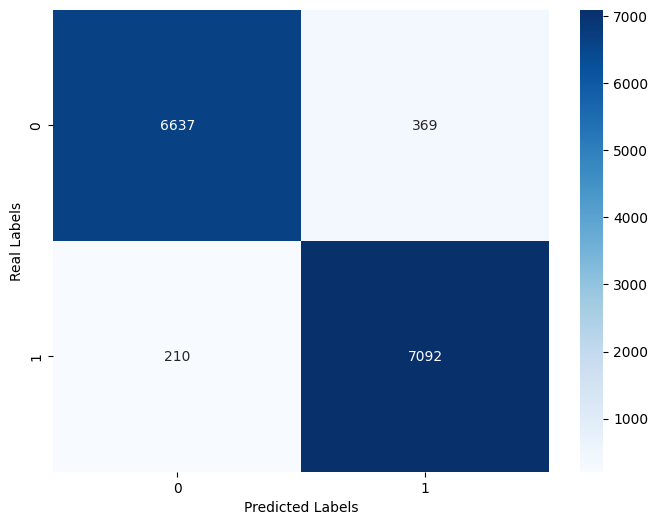

In [14]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test,yhat), annot=True,
            fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')


Salva os modelos e os pesos

In [15]:
model.save('WELFAKE_LSTM32.h5')
model.save_weights("WELFAKE_LSTM_weights32")